# Deep Learning

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using Flux

#statistics
using Random
using Statistics

#visualize
using Plots
pyplot()

#macros
using UnPack
using ProgressMeter

## 1. Hands on

### 1-1. Create Neural Network

In [2]:
#create abstract layer, Neural Network
abstract type AbstractLayer end
abstract type AbstractNeuralNetwork end

#create layer
mutable struct Layer <: AbstractLayer
    d_in::Int32
    d_out::Int32
    zvec::Vector{Float32}
    avec::Vector{Float32}
    error::Vector{Float32}
    weights::Matrix{Float32}
    bias::Vector{Float32}
end

#create neural network
mutable struct NeuralNetwork <: AbstractNeuralNetwork
    n_hiddens::Vector{Int32}
    layers::Vector{Layer}
end

#initialize the layers
function init_layer(d_in, d_out, W_init, b_init)
    return Layer(d_in, d_out, zeros(d_out), zeros(d_out), zeros(d_out), W_init, b_init)
end
init_layer(d_in, d_out) = init_layer(d_in, d_out, randn(d_out,d_in), zeros(d_out))

#initialize the neural network
function init_nn(n_hiddens)
    L = length(n_hiddens)
    layers = Vector{Layer}(undef,L-1)
    for l in 1:L-1
        d_in = n_hiddens[l]
        d_out = n_hiddens[l+1]
        layers[l] = init_layer(d_in, d_out)
    end
    return NeuralNetwork(n_hiddens,layers)
end

init_nn (generic function with 1 method)

### 1-2. Forward and backward pass

In [3]:
#activation function 
function sigmoid(x)
   1 ./ (1 .+ exp.(-x)) 
end

#derivative of sigmoid
function sigmoid_prime(x)
    sigmoid(x) .* (1 .- sigmoid(x))
end

#forward pass
function forward!(x,nn,L)
    avec_prev = x
    for l in 1:L-1
        nn.layers[l].zvec = nn.layers[l].weights * avec_prev + nn.layers[l].bias
        nn.layers[l].avec = sigmoid(nn.layers[l].zvec)
        avec_prev = nn.layers[l].avec
    end
end

#back propagation
function back_prop!(y,nn,L)
    nn.layers[L-1].error = sigmoid_prime(nn.layers[L-1].zvec) .* (nn.layers[L-1].avec-y)
    for l in reverse(1:L-2)
        nn.layers[l].error = sigmoid_prime(nn.layers[l].zvec) .* (nn.layers[l+1].weights' * nn.layers[l+1].error)
    end
end

back_prop! (generic function with 1 method)

### 1-3. Training

In [4]:
#loss function 
function cost(X,Y,nn,L)
    N = size(X,2)
    costs = zeros(N)
    for n in 1:N
        forward!(X[:,n],nn,L)
        costs[n] = norm(Y[:,n]-nn.layers[L-1].avec)^2
    end
    mean(costs)
end

#stochastic gradient descent
function SGD_update!(nn,ε,xvec,L)
    avec_prev = xvec
    for l in 1:L-1
        nn.layers[l].weights -= ε * nn.layers[l].error * avec_prev'
        nn.layers[l].bias -= ε * nn.layers[l].error
        avec_prev = nn.layers[l].avec
    end
end

#training
function my_train(data, nn, n_train, ε)
    @unpack X,Y,N = data
    L = length(nn.n_hiddens)
    costs = zeros(n_train)
    @showprogress for k in 1:n_train
        n = rand(1:N)
        x = X[:,n]
        y = Y[:,n]
        forward!(x,nn,L)
        back_prop!(y,nn,L)
        SGD_update!(nn,ε,x,L)
        costs[k] = cost(X,Y,nn,L)
    end
    return costs
end

my_train (generic function with 1 method)

### 1-4. Experiment

In [5]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#prediction
function pred(x₁,x₂,nn)
    L = length(nn.n_hiddens)
    forward!([x₁,x₂],nn,L)
    return nn.layers[L-1].avec[1]>nn.layers[L-1].avec[2] ? 0 : 1
end

pred (generic function with 1 method)

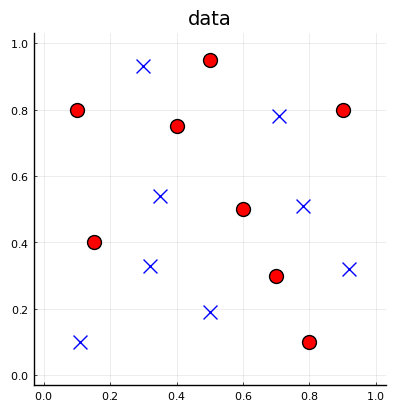

In [6]:
#create the data
N = 16
X = [
    0.11 0.30 0.35 0.32 0.50 0.71 0.78 0.92  0.10 0.15 0.40 0.50 0.60 0.70 0.80 0.90
    0.10 0.93 0.54 0.33 0.19 0.78 0.51 0.32  0.80 0.40 0.75 0.95 0.50 0.30 0.10 0.80
]
labels = vcat(zeros(div(N,2)), ones(div(N,2)))
Y = zeros(2,N)
for n in 1:N
    if labels[n] == 0.0
        Y[1,n] = 1
    else
        Y[2,n] = 1
    end
end
data = (X=X,Y=Y,N=N)

#plot the data
fig1 = plot_data(X,labels)
savefig(fig1, "figs-DL/fig1.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


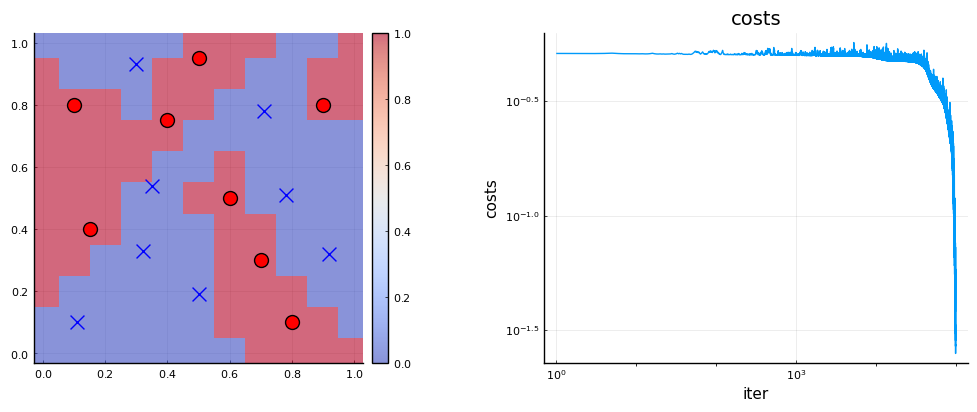

  7.467346 seconds (47.54 M allocations: 5.295 GiB, 15.52% gc time, 32.72% compilation time)


In [7]:
#set the random seed
Random.seed!(42)

#initialize the neural network
n_hiddens = [2,10,10,10,2]
nn = init_nn(n_hiddens)

#training neural entwork
ε = 0.1
n_train = Int(1e5)
@time costs = my_train(data, nn, n_train, ε)

#prediction
p1 = plot(0:0.1:1, 0:0.1:1, (x₁,x₂)->pred(x₁,x₂,nn), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
p1 = plot_data(p1,X,labels)
p2 = plot(costs,xlabel="iter",ylabel="costs",title="costs",xscale=:log10,yscale=:log10,label=false)
fig2 = plot(p1,p2,size=(1000,400))
savefig(fig2, "figs-DL/fig2.png")

## 2. Using Flux

### 2-1. How to use `Flux`

In [8]:
#define and initialize neural network
nn = Chain(
        Dense(2,10,sigmoid),
        Dense(10,10,sigmoid),
        Dense(10,10,sigmoid),
        Dense(10,2,sigmoid)
        )

Chain(
  Dense(2, 10, sigmoid),                # 30 parameters
  Dense(10, 10, sigmoid),               # 110 parameters
  Dense(10, 10, sigmoid),               # 110 parameters
  Dense(10, 2, sigmoid),                # 22 parameters
)                   # Total: 8 arrays, 272 parameters, 1.562 KiB.

In [9]:
#define cost function
function cost(x,y)
    norm(y-nn(x))^2
end

cost (generic function with 2 methods)

In [10]:
#cost before training
sum([cost(X[:,n],Y[:,n]) for n in 1:N])

8.114218200862476

In [11]:
#define optimizer
opt = ADAM()

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [12]:
#training neural network
n = 10
Flux.train!(cost,params(nn),[(X[:,n],Y[:,n])],opt)

In [13]:
#cost after training
sum([cost(X[:,n],Y[:,n]) for n in 1:N])

8.123143853089669

### 2-2. Train the neural network

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


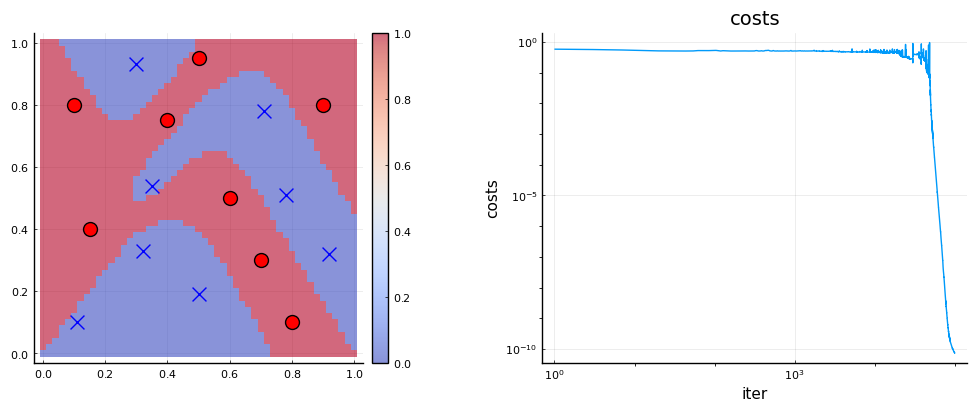

 17.320101 seconds (78.99 M allocations: 6.466 GiB, 8.35% gc time, 0.98% compilation time)


In [14]:
#set the random seed
Random.seed!(42)

#initialize the model
nn = Chain(
        Dense(2,10,sigmoid),
        Dense(10,10,sigmoid),
        Dense(10,10,sigmoid),
        Dense(10,2,sigmoid)
        )

#cost function 
function cost(x,y,nn)
    norm(y-nn(x))^2
end

#training
function my_train(data,nn,n_train)
    @unpack X,Y,N = data
    costs = zeros(n_train)
    opt = ADAM(0.01)
    @showprogress for k in 1:n_train
        n = rand(1:N)
        Flux.train!(cost,params(nn),[(X[:,n],Y[:,n])],opt)
        costs[k] = mean([cost(X[:,n],Y[:,n]) for n in 1:N])
    end
    return costs
end

#train the model
n_train = Int(1e5)
@time costs = my_train(data,nn,n_train)

#prediction 
function pred(x₁,x₂,nn)
    tmp = nn([x₁,x₂])
    return tmp[1]>tmp[2] ? 0 : 1
end

#visualize
p1 = plot(0:0.02:1, 0:0.02:1, (x₁,x₂)->pred(x₁,x₂,nn), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
p1 = plot_data(p1,X,labels)
p2 = plot(costs,xlabel="iter",ylabel="costs",title="costs",xscale=:log10,yscale=:log10,label=false)
fig3 = plot(p1,p2,size=(1000,400))
savefig(fig3, "figs-DL/fig3.png")